In [9]:
import numpy as np
from dualtime.src.mclachlan import VarQITE
from gibbs.utils import create_hamiltonian_lattice,printarray,expected_state,state_from_ansatz, simple_purify_hamiltonian,expected_state, create_heisenberg,animated_hamiltonian
from gibbs.preparation.varqite import brute_force_optimization, efficientTwoLocalansatz
from gibbs.preparation.free_energy import brute_cmaes
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp,Statevector, state_fidelity, DensityMatrix
from gibbs.learning.hamiltonian_learning import HamiltonianLearning
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
beta = 1
local_basis = KLocalPauliBasis(k=2,num_qubits=4,periodic=False)
hamiltonian = create_heisenberg(4,1/4,-1) + SparsePauliOp.from_list([["XIII",1]])
hamiltonian_vec = local_basis.pauli_to_vector(hamiltonian); hamiltonian_vec /= np.linalg.norm(hamiltonian_vec)
hamiltonian = local_basis.vector_to_pauli_op(hamiltonian_vec)
print(hamiltonian)
N = hamiltonian.num_qubits
ansatz,x0 = efficientTwoLocalansatz(hamiltonian,depth = 2,entanglement="reverse_linear",su2_gates=["ry"])
# display(ansatz.decompose().draw(output="mpl"))

SparsePauliOp(['XIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'XXII', 'IXXI', 'IIXX', 'YYII', 'IYYI', 'IIYY', 'ZZII', 'IZZI', 'IIZZ'],
              coeffs=[ 0.42399915+0.j, -0.42399915+0.j, -0.42399915+0.j, -0.42399915+0.j,
 -0.42399915+0.j,  0.10599979+0.j,  0.10599979+0.j,  0.10599979+0.j,
  0.10599979+0.j,  0.10599979+0.j,  0.10599979+0.j,  0.10599979+0.j,
  0.10599979+0.j,  0.10599979+0.j])


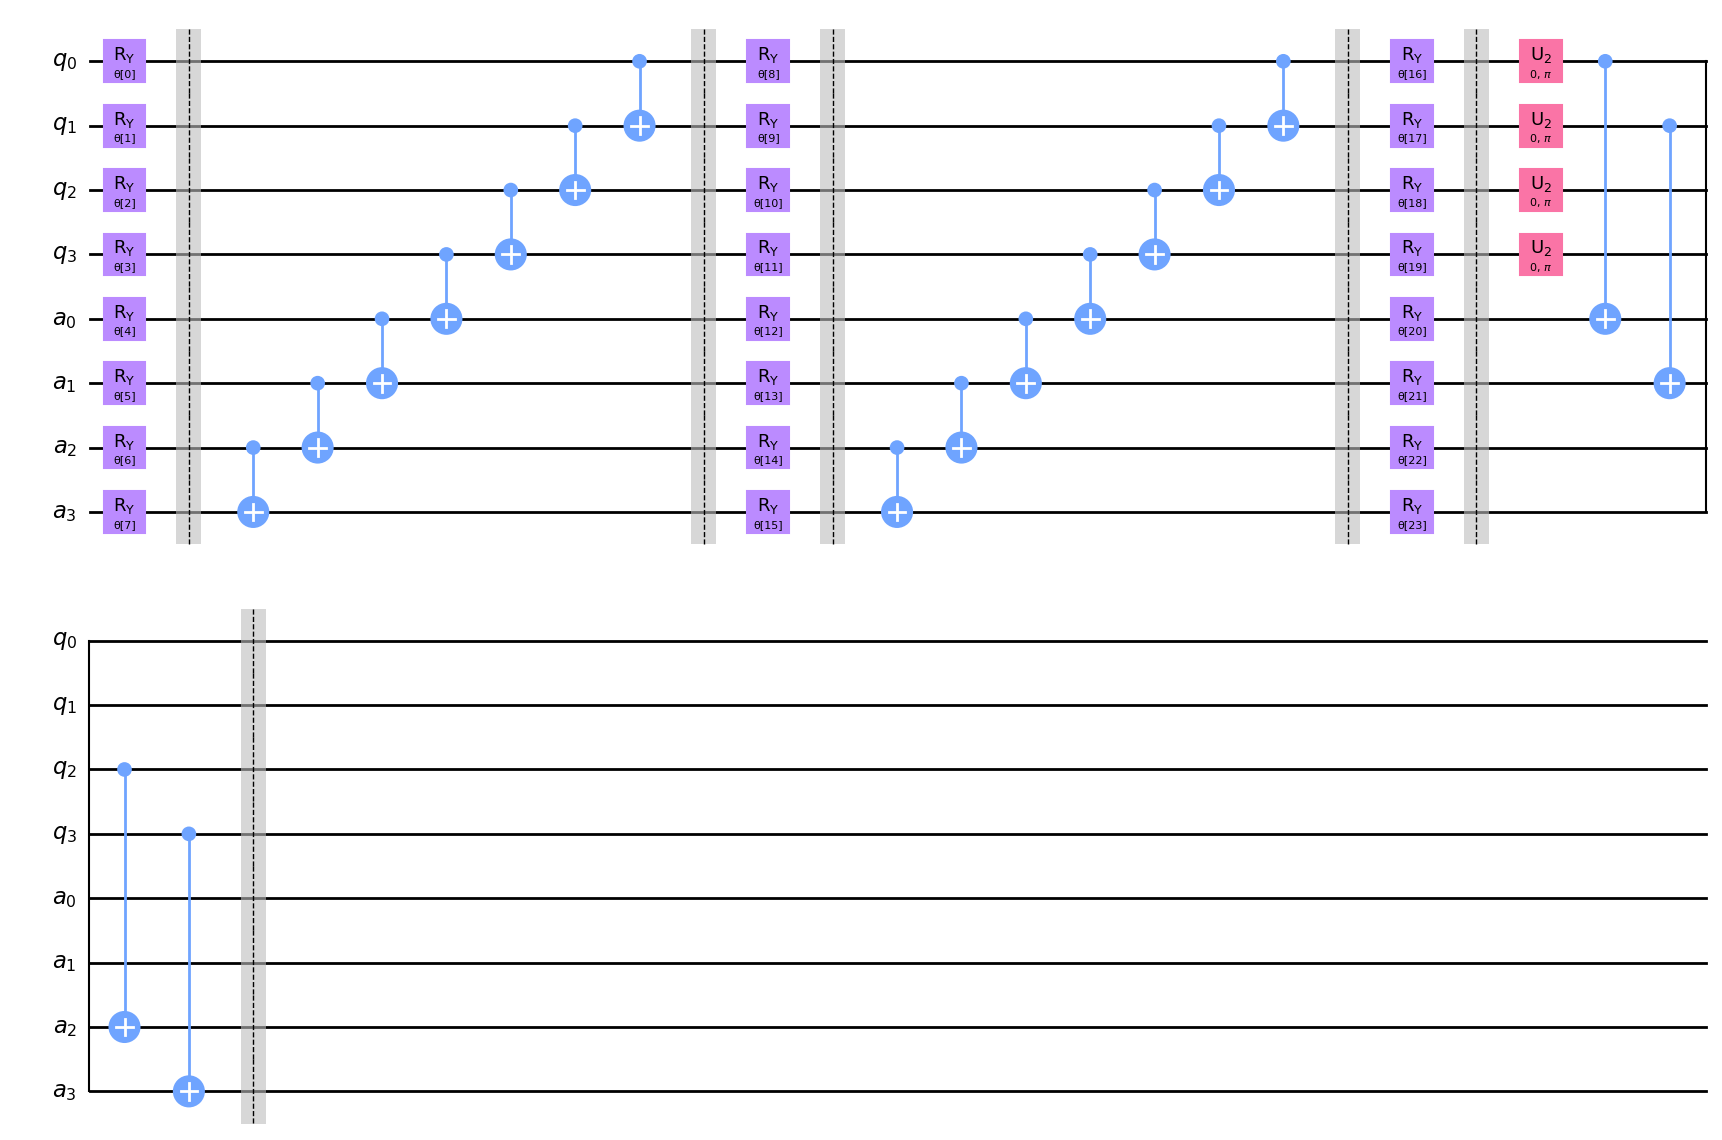

In [13]:
ansatz.decompose().draw(output="mpl")

In [11]:
from qiskit import Aer, transpile
from qiskit_aer import AerError

backend = Aer.get_backend('aer_simulator')
   
varqite = VarQITE(ansatz,x0,backend=backend)
steps = 10
result_varqite = varqite.evolve(PauliSumOp(hamiltonian^("I"*N)),beta/2,timestep = beta/(2*steps))
final_state = state_from_ansatz(ansatz,result_varqite.parameters[-1])
theoretical_state = expected_state(hamiltonian,beta = 2*result_varqite.times[-1])
print("We have gotten a gibbs state with fidelity:",state_fidelity(final_state,theoretical_state))

0
0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
We have gotten a gibbs state with fidelity: 0.7912431298955042


In [7]:
from qiskit import Aer, transpile
from qiskit_aer import AerError

backend = Aer.get_backend('aer_simulator',method="statevector")
backend.__dict__

{'_controller': <qiskit_aer.backends.controller_wrappers.aer_controller_execute at 0x7f8277667270>,
 '_cached_basis_gates': ['ccx',
  'cp',
  'cswap',
  'csx',
  'cu',
  'cu1',
  'cu2',
  'cu3',
  'cx',
  'cy',
  'cz',
  'delay',
  'diagonal',
  'ecr',
  'h',
  'id',
  'initialize',
  'mcp',
  'mcphase',
  'mcr',
  'mcrx',
  'mcry',
  'mcrz',
  'mcswap',
  'mcsx',
  'mcu',
  'mcu1',
  'mcu2',
  'mcu3',
  'mcx',
  'mcx_gray',
  'mcy',
  'mcz',
  'multiplexer',
  'p',
  'pauli',
  'r',
  'roerror',
  'rx',
  'rxx',
  'ry',
  'ryy',
  'rz',
  'rzx',
  'rzz',
  's',
  'sdg',
  'swap',
  'sx',
  'sxdg',
  't',
  'tdg',
  'u',
  'u1',
  'u2',
  'u3',
  'unitary',
  'x',
  'y',
  'z'],
 '_configuration': <qiskit.providers.models.backendconfiguration.QasmBackendConfiguration at 0x7f827750dd50>,
 '_options': Options(shots=1024, method='automatic', device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, enable_truncation=True, zero_threshold=1e-10, validation_thre

/home/drudis/python_environements/JulienVarQITE/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/drudis/python_environements/JulienVarQITE/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


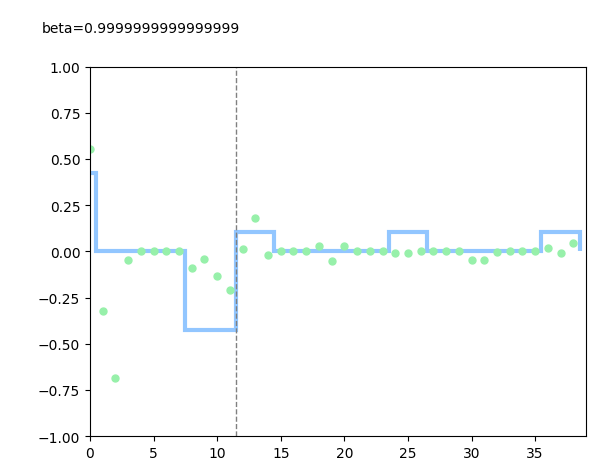

In [12]:
hl = HamiltonianLearning(ansatz,2,3,parameters=result_varqite.parameters,periodic=False)
animated_hamiltonian(hl,H_vec=hamiltonian_vec,name="test",interval = 500,betas = 2*np.array(result_varqite.times))